## Siapkan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Baca Data

In [2]:
train = pd.read_csv("./Datasets/Train.csv")
test = pd.read_csv("./Datasets/Test.csv")

Mari kita salin data latih dan data uji sehingga meskipun kita melakukan perubahan pada dataset, kita tidak kehilangan dataset aslinya.

In [3]:
train_original = train.copy()
test_original = test.copy()

In [4]:
train

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


Mari selami lebih dalam dan lihat kumpulan datanya. pertama-tama mari kita lihat fitur-fitur di dataset train dan test

In [5]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

Pada dataset terdiri dari ID, Datetime, Count yang ada pada data train. untuk data testing hanya memiliki ID dan Datetime yang akan kita prediksi.

Mari kita pahami setiap fitur:
- <b>ID</b> adalah nomor unik yang diberikan untuk setiap titik pengamatan.
- <b>Datetime</b> adalah waktu setiap pengamatan.
- <b>Count</b> adalah jumlah penumpang sesuai dengan setiap Datetime

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

Tipe data dari setiap fitur:
- <b>ID</b> dan <b>Count</b> dalam format integer sedangkan <b>Datetime</b> dalam format objek untuk data train.
- <b>ID</b> dalam bilangan bulat dan <b>Datetime</b> dalam format objek untuk data test.

In [7]:
train.shape,test.shape

((18288, 3), (5112, 2))

Kami memiliki 18288 baris dan 3 kolom pada data train. sedangkan pada data test terdapat 5112 baris dan 2 kolom.

## Ekstraksi Fitur

Kami akan mengekstraksi waktu dan tanggal dari Datetime. Kita telah melihat sebelumnya bahwa tipe Datatime adalah onjek. Jadi pertama-tama kita harus mengubah tipe data ke format datetime jika tidak,kita tidak dapat mengekstraksi fitur darinya.

In [8]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')

train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')

Kami membuat beberapa hipotesis terhadap pengaruh jam, hari, bulan, dan tahun pada jumlah penumpang.

In [9]:
for i in (train, test, train_original, test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

Kami membuat hipotesis untuk pola lalu lintas pada hari kerja dan akhir pekan. Jadi mari kita buat variabel akhir pekan untuk memvisualisasikan dampak akhir pekan terhadap lalu lintas.
- Kami pertama-tama akan mengekstrak hari dalam seminggu dari Datetime dan kemudian berdasarkan nilai yang akan kami tetapkan apakah hari itu adalah akhir pekan atau bukan.
- Nilai 5 dan 6 menunjukan bahwa hari-hari tersebut adalah akhir pekan.

In [10]:
train['day_of_week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

Mari kita tetapkan 1 jika hari dalam seminggu adalah akhir pekan dan 0 jika hari dalam seminggu bukan akhir pekan.

In [11]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

train['weekend'] = train['Datetime'].apply(applyer)

Mari kita lihat rangkaian waktunya.

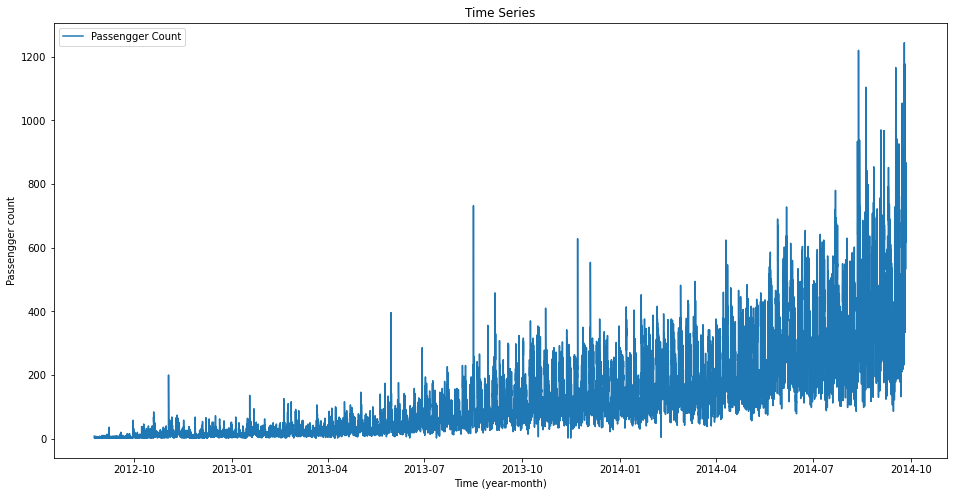

In [12]:
train.index = train['Datetime'] #Indesing datetime untuk mendapatkan waktu
df = train.drop('ID', axis=1) #Menghapus ID untuk emndapatkan semua Datetime
ts = df['Count']

plt.figure(figsize=(16, 8))
plt.plot(ts, label='Passengger Count')
plt.title('Time Series')
plt.xlabel('Time (year-month)')
plt.ylabel('Passengger count')
plt.legend(loc='best')

Dari sini kita dapat menyimpulkan bahwa ada tren peningkatan dalam seri,yaitu jumlah penumpang meningkat terhadap waktu. Kita juga bisa melihat bahwa pada titik-titik tertentu terjadi peningkatan jumlah hitungan secara tiba-tiba. Alasannya yang mungkin dibalik ini adalah bahwa pada hari hari tertentu, karena beberapa peristiwa lalulintas tinggi.

## Analisis Data Eksplorasi

Mari kita ingat hipotesis yang kita buat sebelumnya:
- Lalu lintas akan menigkat seiring tahun-tahun berlalu.
- Lalu lintas akan tinggi dari Mei hingga Oktober.
- Lalu lintas di hari kerja akan lebih banyak.
- Lalu lintas selamajam sibuk akan tinggi.

Setelah melihat dataset, sekarang kita akan mencoba memvalidasi hipotesis kita dan membuat kesimpulan lain dari dataset.

<AxesSubplot:xlabel='year'>

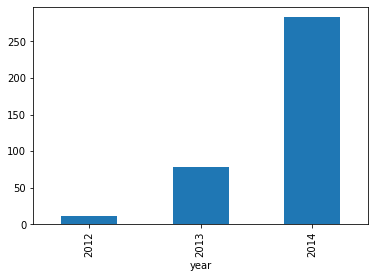

In [13]:
"""
Hipotesis pertama kami adalah lalu lintas akan meningkat seiring berjalannya waktu.
Jadi mari kita lihat jumlah penumpang tahunan.
"""

train.groupby('year')['Count'].mean().plot.bar()

Kami melihat pertumbuhan eksponensial dalam lalu lintas sehubungan dengan tahun yang memvalidasi hipotesis kami.

<AxesSubplot:xlabel='month'>

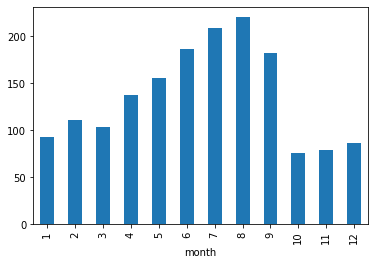

In [14]:
"""
Hipotesis kedua kami adalah tentang peningkatan lalu lintas dari Mei hingga Oktober.
Jadi mari kita lihat hubungan antara peningkatan jumlah lalu lintas dan bulan.
"""

train.groupby('month')['Count'].mean().plot.bar()

Disini kita melihat penurunan rata-rata jumlah penumpang dalam tiga bulan terakhir. Ini tidak terlihat benar. Mari kita lihat rata-rata bulanan setiap tahun secara terpisah.

<AxesSubplot:title={'center':'Passenggger Count (MonthWise)'}, xlabel='year,month'>

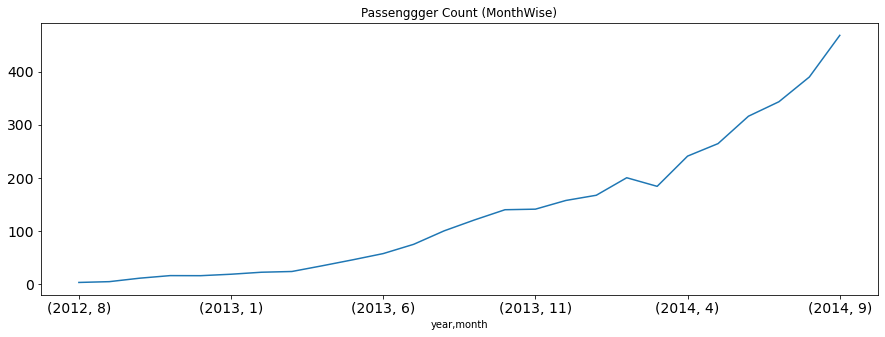

In [15]:
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15,5), title='Passenggger Count (MonthWise)', fontsize=14)

- Kami melihat bahwa bulan 10, 11, dan 12 tidak ada untuk tahun 2014 dan nilai rata-rata untuk bulan-bulan tersebut di tahun 2012 sangat kurang.
- Karena ada tren peningkatan dalam rangkaian waktu kami, nilai rata-rata untuk sisa bulan akan lebih banyak karena jumlah penumpang yang lebih besar di tahun 2014 dan kami akan mendapatkan nilai yang lebih kecil untuk 3 bulan ini.
- Pada plot garis diatas kita dapat melihat tren peningkatan jumlah penumpang bulanan dan pertumbuhannya kira-kira eksponensial.

<AxesSubplot:xlabel='day'>

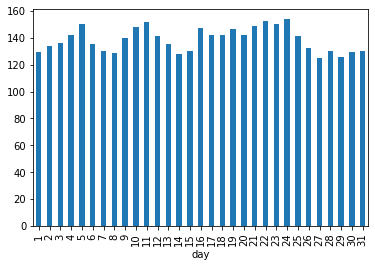

In [16]:
"""Mari kita lihat rata-rata harian jumlah penumpang"""

train.groupby('day')['Count'].mean().plot.bar()

Kami tidak mendapatkan banyak wawasan dari jumlah penumpang setiap hari.

<AxesSubplot:xlabel='hour'>

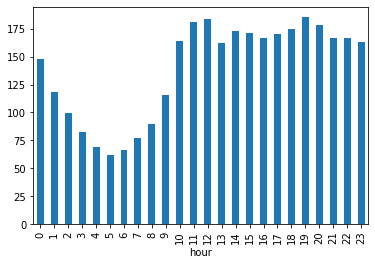

In [17]:
"""
Kami juga membuat hipotesis bahwa lalu lintas akan lebuh ramai pada jam sibuk.
Jadi mari kita lihat rata-rata jumlah penumpang perjam.
"""

train.groupby('hour')['Count'].mean().plot.bar()

- Dapat disimpulkan bahwa puncak trafik terjadi pada pukul 19.00 WIB dan kemudian terlihat tren penurunan hingga pukul 05.00 WIB.
- Setelah itu jumlah penumpang mulai meningkat lagi dan mencapai puncaknya lagi antara pukul 11 pagi hingga 12 siang.

<AxesSubplot:xlabel='weekend'>

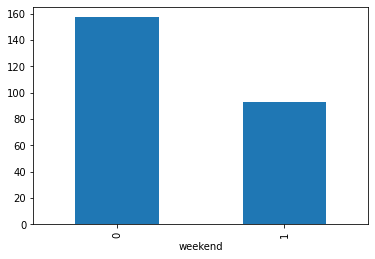

In [18]:
"""
Mari kita coba untuk memvalidasi hipotesis kita dimana kita berasumsi bahwa lalu lintas
akan lebuh banyak pada hari kerja.
"""

train.groupby('weekend')['Count'].mean().plot.bar()

Dapat disimpulkan bahwa dari plot diatas bahwa lalu lintas lebih banyak pada hari kerja dibandingkan dengan akhir pekan yang memvalidasi hipotesis kami.

<AxesSubplot:xlabel='day_of_week'>

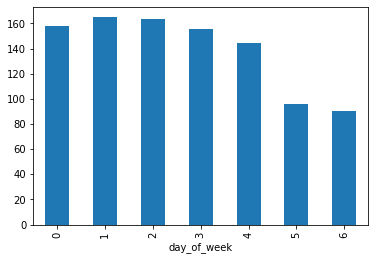

In [19]:
"""
Sekarang kita akan mencoba melihat jumlah penumpang berdasarkan hari
Catatan: 0 adalah awal minggu, yaitu 0 adalah senin dan 6 adalah minggu
"""

train.groupby('day_of_week')['Count'].mean().plot.bar()

Dari grafik diatas, kita dapat menyimpulkan bahwa jumlah penumpang untuk hari Sabtu dan Minggu lebuh sedikit dibandingkan dengan hari-hari lain dalam seminggu. Sekarang kita akan melihat teknik pemodelan dasar.Sebelum itu kami akan menghapus variabel ID karena tidak ada hubungannya dengan jumlah penumpang.

In [20]:
train = train.drop('ID', axis=1)

Seperti yang kita lihat bahwa ada banyak noise dalam deret waktu perjam, kita akan menggabungkan deret waktu perjam ke deret waktu harian, mingguan, dan bulanan untuk mengurangi kebisingan dan membuatnya lebih stabil dan karenanya akan lebih mudah untuk sebuah model untuk mempelajari.

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()
# Converting to daily mean
daily = train.resample('D').mean()
# Converting to weekly mean
weekly = train.resample('W').mean()
# Converting to monthly mean
monthly = train.resample('M').mean()

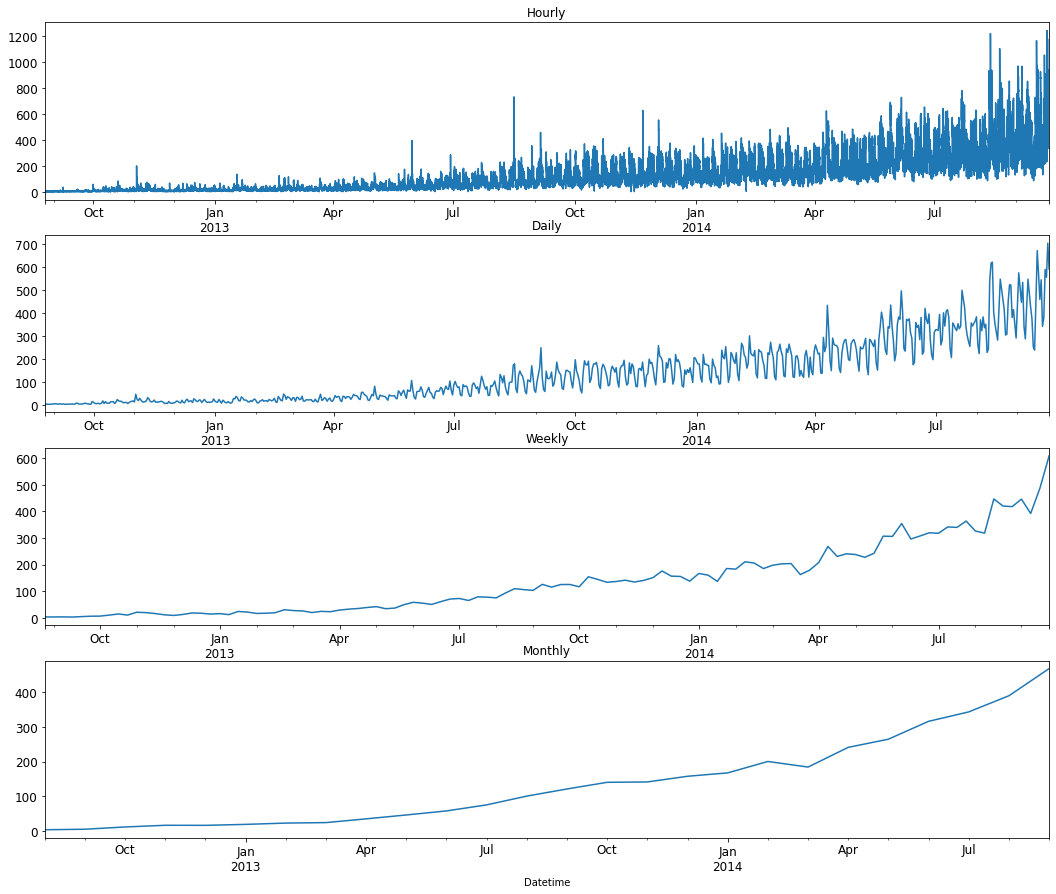

In [22]:
fig, axs = plt.subplots(4, 1)
hourly.Count.plot(figsize=(18, 15), title='Hourly', fontsize=12, ax=axs[0])
daily.Count.plot(figsize=(18, 15), title='Daily', fontsize=12, ax=axs[1])
weekly.Count.plot(figsize=(18, 15), title='Weekly', fontsize=12, ax=axs[2])
monthly.Count.plot(figsize=(18, 15), title='Monthly', fontsize=12, ax=axs[3])

plt.show()

Kita dapat melihat bahwa deret waktu menjadi lebih dan lebih stabil ketika kita menggabungkannya secara harian, mingguan dan bulanan.

Tetapi akan sulit untuk mengubah prediksi bulanan dan mingguan menjadi prediksi per jam, karena pertama-tama kita harus mengubah bulanan menjadi mengguan, mingguan ke harian dan harian ke prediksi per jam, yang akan  menjadi proses yang sulit diperluas. jadi,kami akan mengerjakan waktu harian.

In [23]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp

# Converting to daily mean
test = test.resample('D').mean()

In [24]:
test

,ID,year,month,day,hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5
...,...,...,...,...,...
2015-04-22,23291.5,2015.0,4.0,22.0,11.5
2015-04-23,23315.5,2015.0,4.0,23.0,11.5
2015-04-24,23339.5,2015.0,4.0,24.0,11.5


In [25]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

In [26]:
train

,Count,year,month,day,hour,day_of_week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0


## Memisahkan data menjadi bagian pelatihan dan validasi

Tanggal awal dataset adalah 25-08-2012 seperti yang telah kita lihat dibagian ekplorasi dalam tanggal akhir adalah 25-09-2014.

In [27]:
X_train = train.loc['2012-08-25':'2014-06-24']
X_valid = train.loc['2014-06-25':'2014-09-25']

Untuk pembagian data menjadi training dan set validasi:
- Kami telah melakukan validasi berbasis waktu disini dengan memilih 3 bulan terakhir untuk data validasi dan sisanya menjadi data training. Jika kita akan melakukannya secara acak mungkin bekerja dengan baik untuk data training tetapi tidak akan bekerja efektif untuk data validasi.
- Mari kita pahami dengan cara ini: jika kita memilih split secara acak, itu akan mengambil beberapa nilai dari awal waktu dan beberapa nilai pada tahun-tahun terakhir juga. Ini mirip dengan memprediksi nilai-nilai lama berdasarkan nilai-nilai masa depan yang tidak terjadi dalam skenario nyata. Jadi, jenis spit ini digunakan saat bekerja dengan masalah terkait waktu.

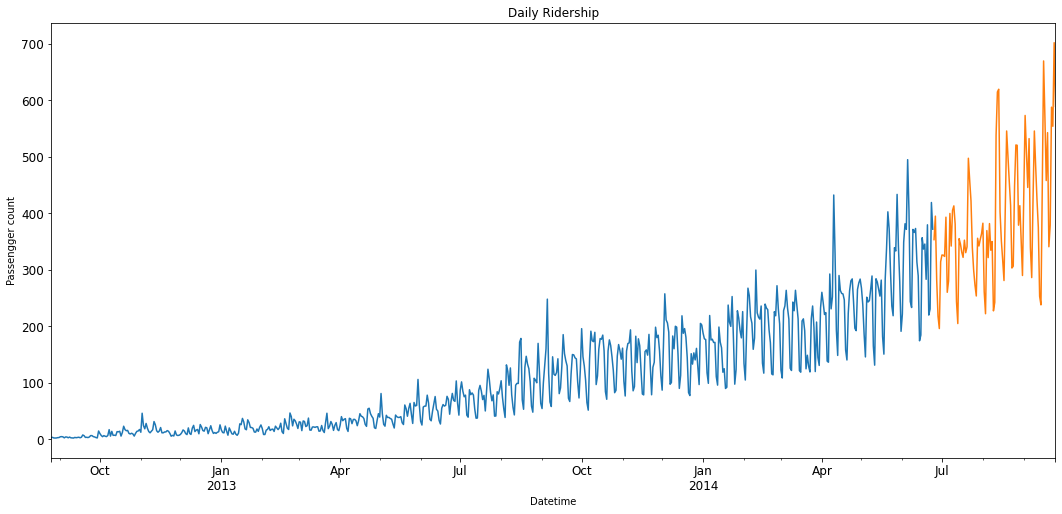

In [28]:
X_train.Count.plot(figsize=(18, 8), title='Daily Ridership', fontsize=12, label='train')
X_valid.Count.plot(figsize=(18, 8), title='Daily Ridership', fontsize=12, label='valid')
plt.xlabel('Datetime')
plt.ylabel('Passengger count')
plt.show()

Di sini bagian biru mewakili data tarin dan oranye mewakili data validasi.

Kami akan memprediksi lalu lintas untuk bagian validasi dan akan mevisualisasikan seberapa akurat prediksi kami. Sebelum kami akan memprediksi untuk dataset uji.

## Teknik Pemodelan

Kita akan melihat berbagai model untuk meramalkan deret waktu. Metode yang akan kita bahas adalah:
- Naive Approach
- Moving Averange
- Simple Exponential Smoothing
- Holt's Linear Tren Model

Kami akan membahas masing-masing metode ini secara rinci sekarang.

### Naive Approach
- Dalam teknik peramalan ini, kita mengasumsikan bahwa titik harapan berikutnya sama dengan titik pengamatan terakhir. Jadi kita bisa mengharapkan garis horizontal lurus sebagai prediksi.

Mari kita lakukan prediksi menggunakan pendekatan Naive Approach terhadap set validasi.

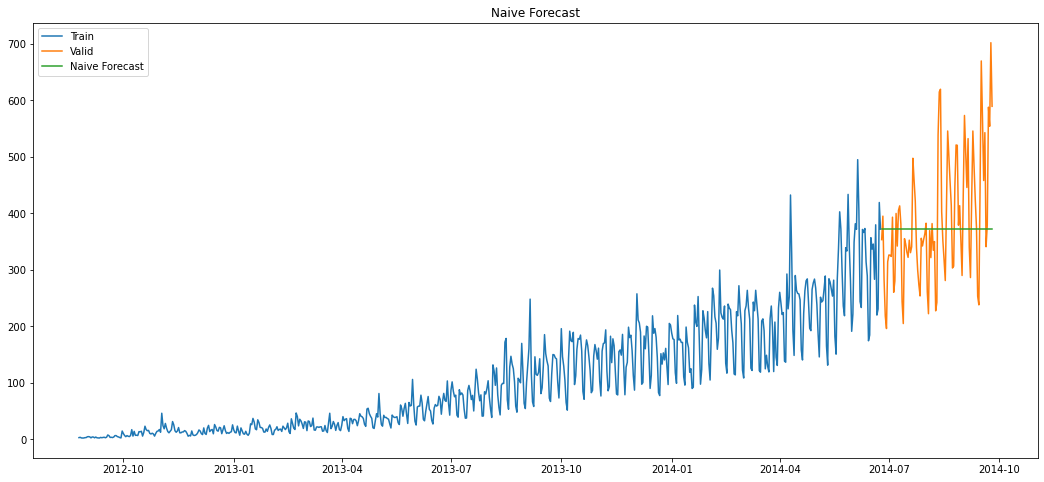

In [29]:
dd = np.array(X_train.Count)
y_hat = X_valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(18, 8))
plt.plot(X_train.index, X_train.Count, label='Train')
plt.plot(X_valid.index, X_valid.Count, label='Valid')
plt.plot(y_hat.index, y_hat.naive, label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

#### Pengetahuan
- Kita dapat menghitung seberapa akurat prediksi kita menggunakan rsme (Root Mean Square Error)
- Rmse adalah standar deviasi dari residual
- Residual adalah ukuran seberapa jauh dari titik data garis regresi
- Rumus untuk rmse

<i>silahkan klik link berikut</i>
[link ke rumus rmse](https://en.wikipedia.org/wiki/Root-mean-square_deviation/)



Kami akan mengitung RMSE untuk memeriksa keakuratan model kami pada kumpulan data validasi.

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(X_valid.Count, y_hat.naive))
print(rms)

111.79050467496724


#### Pengetahuan
Kita dapat menyimpulkan bahwa metode ini tidak cocok untuk kumpulan data dengan variabilitas tinggi. Kita dapat mengurangi nilai rmse dengan mengadopsi metode yang berbeda.

### Moving Averange
- Dalam teknik ini kita akan mengambil rata-rata jumlah penumpang untuk beberapa periode waktu terakhir saja.

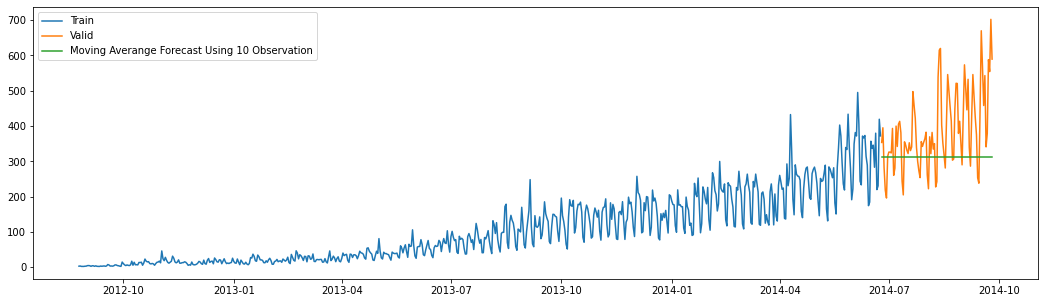

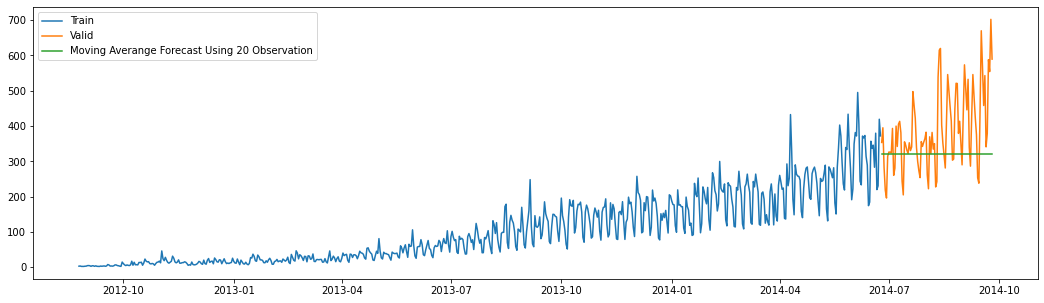

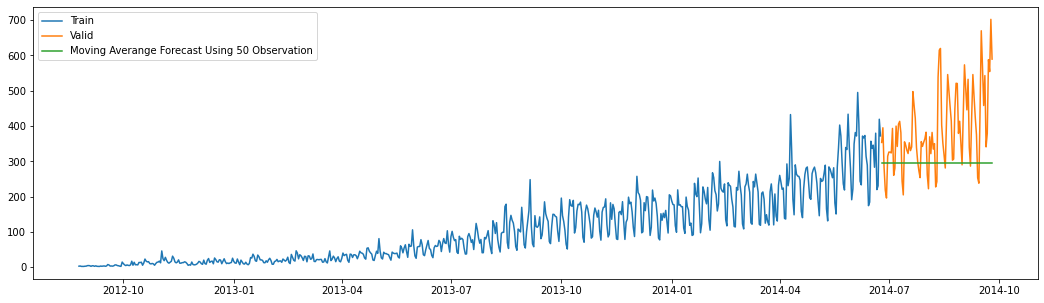

In [31]:
y_hat_avg = X_valid.copy()
y_hat_avg['moving_avg_forecast'] = X_train.Count.rolling(10).mean().iloc[-1] # averange of last 10 observation
plt.figure(figsize=(18, 5))
plt.plot(X_train.Count, label='Train')
plt.plot(X_valid.Count, label='Valid')
plt.plot(y_hat_avg.moving_avg_forecast, label='Moving Averange Forecast Using 10 Observation')
plt.legend(loc='best')
plt.show()

y_hat_avg = X_valid.copy()
y_hat_avg['moving_avg_forecast'] = X_train.Count.rolling(20).mean().iloc[-1] # averange of last 20 observation
plt.figure(figsize=(18, 5))
plt.plot(X_train.Count, label='Train')
plt.plot(X_valid.Count, label='Valid')
plt.plot(y_hat_avg.moving_avg_forecast, label='Moving Averange Forecast Using 20 Observation')
plt.legend(loc='best')
plt.show()

y_hat_avg = X_valid.copy()
y_hat_avg['moving_avg_forecast'] = X_train.Count.rolling(50).mean().iloc[-1] # averange of last 50 observation
plt.figure(figsize=(18, 5))
plt.plot(X_train.Count, label='Train')
plt.plot(X_valid.Count, label='Valid')
plt.plot(y_hat_avg.moving_avg_forecast, label='Moving Averange Forecast Using 50 Observation')
plt.legend(loc='best')
plt.show()

In [32]:
rms = sqrt(mean_squared_error(X_valid.Count, y_hat_avg.moving_avg_forecast))
print(rms)

144.19175679986793


#### Pengetahuan
Kami mengambil rata-rata 10, 20 dan 50 pengamatan terakhir dan memprediksi berdasarkan itu. Nilai ini dapat diubah dalam kode diatas dibagian .rollong().mean(). Kita dapat melihat bahwa prediksi semakin lemah seiring dengan bertambahnya jumlah pengamatan.

### Simple Exponential Smoothing
- Dalam teknik ini, kami menetapkan bobot yang lebih besar untuk pengamatan yang lebih baru daripada pengamatan dari masa lalu yang jauh.
- Bobot berkurang secara exponensial saat pengamatan lebih jauh dimasa lalu, bobot kecil dikaitkan dengan pengamatan tertua.

<b>CATATAN</b> - Jika kita memberikan seluruh bobot pada nilai pengamatan terakhir saja, metode ini akan mirip dengan naive approach. Jadi, kita dapat mengatakan bahwa naive approach juga merupakan teknik simple exponential smoothing sederhana dimana seluruh bobot diberikan pada nilai pengamatan terakhir.

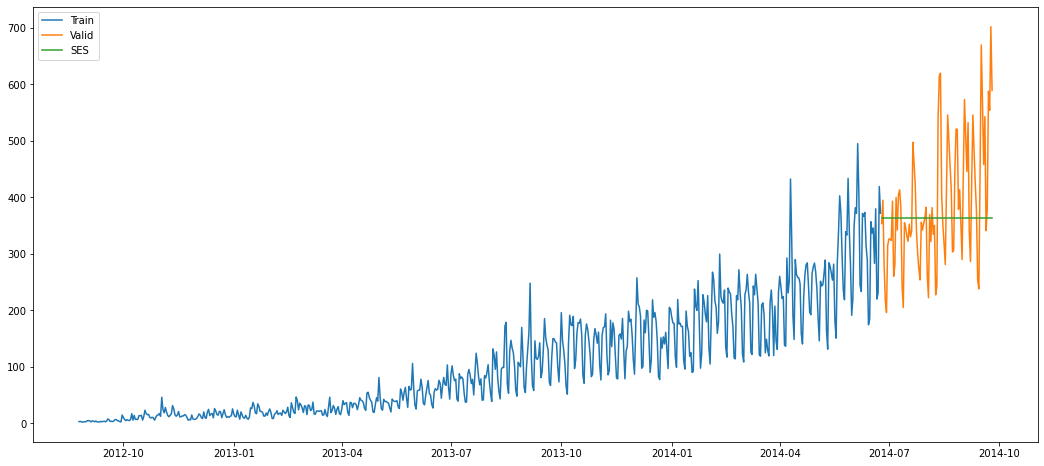

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = X_valid.copy()
fit = SimpleExpSmoothing(np.asarray(X_train.Count)).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit.forecast(len(X_valid))

plt.figure(figsize=(18, 8))
plt.plot(X_train.Count, label='Train')
plt.plot(X_valid.Count, label='Valid')
plt.plot(y_hat_avg.SES, label='SES')
plt.legend(loc='best')
plt.show()

In [34]:
rms = sqrt(mean_squared_error(X_valid.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


#### Pengetahuan
- Kita dapat menyimpulkan bahwa kecocokan model telah meningkat karena nilai RMSE telah berkurang.

### Holt's Linear Trend Model
- Ini adalah perpanjangan dari Simple Eksponential Smoothing sederhana untuk memungkinkan permasalahan data dengan tren.
- metode ini memperhitungkan tren kumpulan data. Fungsi forecast dalam metode ini adalah fungsi dari level dan tren.

Pertama-tama mari kita visualisasikan trend, seasonality dan error dalam rangkaian.
kita dalam menguraikan deret waktu dalam empat bagian:
- Observed, yang merupakan deret waktu asli.
- Trend, yang menunjukan tren dalam time series, yaitu perilaku naik atau turun dari time series. 
- Seasonal, yang memberi tahu kita tentang musiman dalam deret waktu.
- Residual, yang diperoleh dengan menghilangkan tren atau musiman dalam deret waktu.

Mari kita visualisasikan bagian ini!

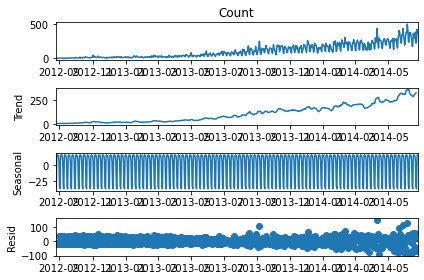

In [35]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(X_train.Count).plot()
result = sm.tsa.stattools.adfuller(X_train.Count)
plt.show()

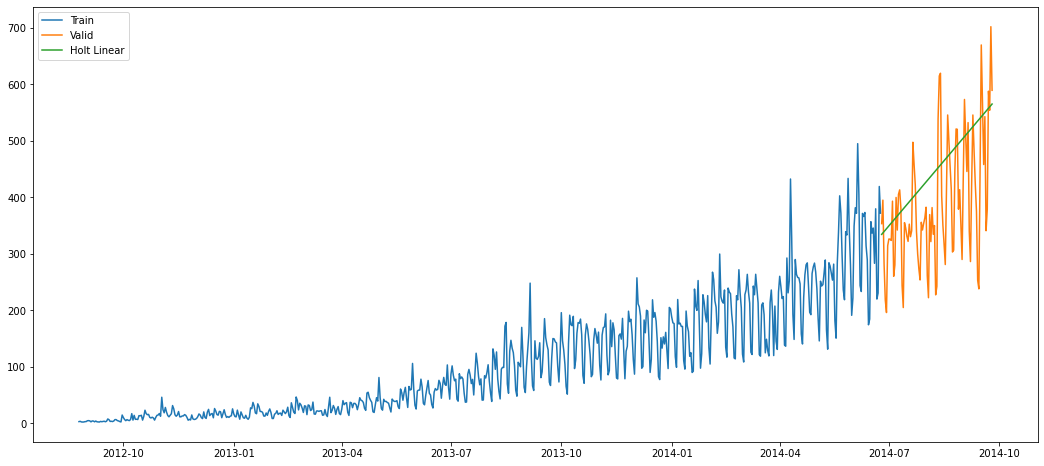

In [36]:
"""
Trend yang meningkat dapat dilihat pada dataset, jadi kita akan membuat model berdasarkan tren.
"""

y_hat_avg = X_valid.copy()
fit = Holt(np.asarray(X_train.Count)).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['holt_linear'] = fit.forecast(len(X_valid))

plt.figure(figsize=(18, 8))
plt.plot(X_train.Count, label='Train')
plt.plot(X_valid.Count, label='Valid')
plt.plot(y_hat_avg.holt_linear, label='Holt Linear')
plt.legend(loc='best')
plt.show()

Kita dapat melihat garis miring disini karena model telah mempertimbangkan tren deret waktu.
Mari kita hitung RMSE modelnya!.

In [37]:
rms = sqrt(mean_squared_error(X_valid.Count, y_hat_avg.holt_linear))
print(rms)

112.94278345314041


#### Pengetahuan
Dapat disimpulkan bahwa nilai RMSE mengalami penurunan.

Sekarang kita akan memprediksi dataset uji dengan berbagai model!!!.

#### Holt's Linear Trend Model on Daily Time Series
- Sekarang mari kita coba membuat model holt's linear pada time series harian dan membuat prediksi pada dataset uji.
- Kami akan membuat prediksi berdasarkan time series harian dan kemuadian akan mendistribusikan prediksi harian tersebut ke prediksi per jam.
- Kami telah memasang model holt's linear trend pada dataset training dan memvalidasinya menggunakan dataset validasi.

In [38]:
# Memuat file pengiriman
submission = pd.read_csv('./Datasets/submission.csv')

In [39]:
# Membuat prediksi untuk dataset pengujian
predict = fit.forecast(len(test))
# Mari simpan prediksi ini dalam file uji di kolom baru
test['prediction'] = predict

Ingat ini adalah prediksi harian. Kita harus mengubah prediksi ini menjadi basis per jam. unutk melakukannya, pertama-tama kita akan menghitung rasio jumlah penumpang untuk setiap jam setiap hari. kemudian kita akan menemukan rasio rata-rata jumlah penumpang untuk setiap jam dan kita akan mendapatkan 24 rasio. Kemudian untuk menghitung prediksi per jam kita akan mengalikan prediksi harian dengan rasio perjam.

In [40]:
# Calculating the hourly ratio of count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

In [42]:
# Groupign the hourly ratio
temp = train_original.groupby(['hour'])['ratio'].sum()

In [43]:
# Groupby to csv format
pd.DataFrame(temp, columns=['hour', 'ratio']).to_csv('./Datasets/groupby.csv')

In [44]:
temp2 = pd.read_csv('./Datasets/groupby.csv')
temp2 = temp2.drop('hour.1', 1)

In [45]:
# Marge test and test_original on day, mont adn year
merge = pd.merge(test, test_original, on=('day','month','year'), how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year','month','Datetime','hour_x','hour_y'], axis=1)

In [47]:
# Predicting by merging and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')

In [48]:
# Converting the ratio to the original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID'] = prediction['ID_y']

In [49]:
"""
Mari kita lepaskan semua fitur lain dari file pengiriman dan pertahankan ID dan Count
"""
submission = prediction.drop(['ID_x','day','ID_y','prediction','hour','ratio'], axis=1)

In [50]:
# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('./Datasets/holt_linear.csv')

Model holt's linear memberikan nilai RMSE 274,1596 di papan peringkat

#### Holt Winter's Model on Daily Time Series